# Problem context

## ETL Pipeline for Unstructured PDF Data Extraction

### Overview
This notebook implements an end-to-end ETL pipeline that extracts structured information from unstructured PDF files (text-based, tabular, and scanned images), transforms and cleans the data, loads it into a structured format, performs analysis, and generates automated reports.

### Dataset Sources
The pipeline processes three types of documents:

1. **Jordan Construction Specifications** (`jordan_book/`)
   - Text-heavy contract specification document
   - Source: [Jordan 2019 Standard Specifications for Construction](https://clients.bolton-menk.com/jordanengineering/wp-content/uploads/sites/44/2019/12/Jordan-2019-Standard-Specifications-for-Construction.pdf)

   ![image.png](contract.png)

2. **Invoice Dataset** (`invoice_dataset/`)
   - Invoices Images
   -  Source: [Invoices Dataset from kaggle](https://www.kaggle.com/datasets/osamahosamabdellatif/high-quality-invoice-images-for-ocr)

   ![image-2.png](invoice.png)

   - Optmiziation Reference:
      - https://www.kaggle.com/code/vermaavi/invoice-data-extraction-using-smolvlm


3. **Receipts Dataset** (`receipts_dataset/`)
   - Scanned receipts requiring OCR processing
   - Receipts Images
   - Source: [Receipts Dataset from Kaggle](https://www.kaggle.com/datasets/trainingdatapro/ocr-receipts-text-detection)

   ![image-3.png](receipt.png)

   - Optimization Reference:
      - https://www.kaggle.com/code/gabrielvinicius/vision-models-llama-and-florence-2

### Pipeline Components
- **Extract**: Parse PDFs and extract key fields (IDs, names, descriptions, line items)
- **Transform**: Normalize and clean data with consistent schema
- **Load**: Store structured data for analysis
- **Analyze**: Generate insights and statistics
- **Report**: Automated report generation

# Proposed solution: AI Powered ETL Process

## Libraries and Initial configs

In [1]:
# AI libraries
from langgraph.graph import StateGraph, END, START
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate


# Data handling libraries
import pandas as pd
import json
from pathlib import Path
from typing import TypedDict, Literal, Annotated
from datetime import datetime
import re

# Progress bar
from tqdm.auto import tqdm

# Logging and Tracing (Data Quality and Monitoring)
import logging
import mlflow

# PDF processing libraries
import pdfplumber  # text from PDFs
import tabula  # tables from PDFs
import pytesseract  #  OCR for scanned images
from PIL import Image
import io

# Visualization libraries
# Imports para visualização
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


In [2]:
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger("ai-powered-etl-process")

mlflow.langchain.autolog()

In [3]:
# DEFINITIONS

# Define base paths
BASE_DIR = Path.cwd().parent.parent  # Navigate up from notebook to project root
DATA_INPUT = BASE_DIR / "data" / "input"
DATA_OUTPUT = BASE_DIR / "data" / "output"
REPORTS_DIR = BASE_DIR / "reports"

# Define input subdirectories
JORDAN_BOOK_DIR = DATA_INPUT / "jordan_book"
INVOICE_DIR = DATA_INPUT / "invoice_dataset"
RECEIPTS_DIR = DATA_INPUT / "receipts_dataset"

# Ensure output directories exist
DATA_OUTPUT.mkdir(parents=True, exist_ok=True)
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

logging.info(f"Project Structure:")
logging.info(f"  Base: {BASE_DIR}")
logging.info(f"  Input: {DATA_INPUT}")
logging.info(f"  Output: {DATA_OUTPUT}")
logging.info(f"  Reports: {REPORTS_DIR}")
logging.info(f"\n Input Subdirectories:")
logging.info(f"  Contracts: {JORDAN_BOOK_DIR}")
logging.info(f"  Invoices: {INVOICE_DIR}")
logging.info(f"  Receipts: {RECEIPTS_DIR}")

2025-11-04 21:00:53,746 - root - INFO - Project Structure:
2025-11-04 21:00:53,747 - root - INFO -   Base: /Users/viniciusgribas/Code/github/work/teste_alvorada_dev
2025-11-04 21:00:53,747 - root - INFO -   Input: /Users/viniciusgribas/Code/github/work/teste_alvorada_dev/data/input
2025-11-04 21:00:53,748 - root - INFO -   Output: /Users/viniciusgribas/Code/github/work/teste_alvorada_dev/data/output
2025-11-04 21:00:53,748 - root - INFO -   Reports: /Users/viniciusgribas/Code/github/work/teste_alvorada_dev/reports
2025-11-04 21:00:53,748 - root - INFO - 
 Input Subdirectories:
2025-11-04 21:00:53,748 - root - INFO -   Contracts: /Users/viniciusgribas/Code/github/work/teste_alvorada_dev/data/input/jordan_book
2025-11-04 21:00:53,748 - root - INFO -   Invoices: /Users/viniciusgribas/Code/github/work/teste_alvorada_dev/data/input/invoice_dataset
2025-11-04 21:00:53,749 - root - INFO -   Receipts: /Users/viniciusgribas/Code/github/work/teste_alvorada_dev/data/input/receipts_dataset
2025-11

### Model


In [4]:
# API Keys and environment variables configuration
import os
from dotenv import load_dotenv

# Load environment variables from the .env file
load_dotenv()

# Validate that the API key is configured
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
if not OPENAI_API_KEY:
    raise ValueError(
        "❌ OPENAI_API_KEY not found. "
        "Create a .env file based on .env.example"
    )


OPENAI_DEFAULT_MODEL = os.getenv("OPENAI_MODEL", "gpt-4o-mini")
OPENAI_REASONING_MODEL = os.getenv("OPENAI_REASONING_MODEL", "gpt-5-mini")
OPENAI_TEMPERATURE = float(os.getenv("OPENAI_TEMPERATURE", "0.1"))

llm_default = ChatOpenAI(
    model=OPENAI_DEFAULT_MODEL,
    temperature=OPENAI_TEMPERATURE,
    api_key=OPENAI_API_KEY,
)

llm_reasoning = ChatOpenAI(
    model=OPENAI_REASONING_MODEL,
    temperature=OPENAI_TEMPERATURE,
    api_key=OPENAI_API_KEY,
)

logging.info(f"Using OpenAI Model: {OPENAI_DEFAULT_MODEL} for default tasks")
logging.info(f"Using OpenAI Model: {OPENAI_REASONING_MODEL} for reasoning tasks")


2025-11-04 21:00:53,867 - root - INFO - Using OpenAI Model: gpt-4o-mini for default tasks
2025-11-04 21:00:53,868 - root - INFO - Using OpenAI Model: gpt-5-mini for reasoning tasks
2025-11-04 21:00:53,868 - root - INFO - Using OpenAI Model: gpt-5-mini for reasoning tasks


In [5]:
# simple call

# llm test
response_llm_default = llm_default.invoke(
    [
        HumanMessage(content="Hello, how are you?")
    ]
)
response_llm_default.content

2025-11-04 21:00:55,413 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


"Hello! I'm just a computer program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?"

In [6]:
response_llm_reasoning = llm_reasoning.invoke(
    [
        HumanMessage(content="Hello, how are you?")
    ]
)
response_llm_reasoning.content

2025-11-04 21:00:57,490 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


"I'm doing well, thanks — how are you? How can I help you today?"

## Utilities

### Data Loading

In [7]:
# Function to list image and PDF files in a directory
def list_input_files(directory: Path, max_files: int = None) -> list[Path]:
    """
    List PDF and image files (jpg, jpeg, png) in a directory.
    
    Args:
        directory: Path to directory
        max_files: Maximum number of files to return (None = all)
    
    Returns:
        List of file paths
    """
    if not directory.exists():
        print(f"⚠️  Directory not found: {directory}")
        return []
    
    # Support both PDFs and images
    files = []
    for extension in ["*.pdf", "*.jpg", "*.jpeg", "*.png", "*.JPG", "*.JPEG", "*.PNG"]:
        files.extend(directory.glob(extension))
    
    files = sorted(files)
    
    if max_files:
        files = files[:max_files]
    
    return files


In [8]:
# Function to categorize document by directory and filename
def categorize_document(file_path: Path) -> Literal["invoice", "contract", "receipt"]:
    """
    Detect document type based on parent directory and filename.
    
    Args:
        file_path: Path to the document file
    
    Returns:
        Document type: 'invoice', 'contract', or 'receipt'
    """
    # Check parent directory first (most reliable)
    parent_name = file_path.parent.name.lower()
    
    if "jordan" in parent_name or "contract" in parent_name:
        return "contract"
    elif "invoice" in parent_name:
        return "invoice"
    elif "receipt" in parent_name:
        return "receipt"
    
    # Fallback: check filename
    filename_lower = file_path.name.lower()
    if any(kw in filename_lower for kw in ["invoice", "bill"]):
        return "invoice"
    elif any(kw in filename_lower for kw in ["contract", "contrato", "agreement", "specification", "jordan"]):
        return "contract"
    elif any(kw in filename_lower for kw in ["receipt", "ticket"]):
        return "receipt"
    
    # Final fallback
    print(f"⚠️  Type not detected for '{file_path.name}', assuming 'invoice'")
    return "invoice"

## States

### Structured Outputcs SubStates

In [9]:
from pydantic import BaseModel, Field
from typing import Optional, List

# Line Item model (shared by all document types)
class LineItem(BaseModel):
    """Represents a single line item in an invoice, receipt, or contract."""
    description: str = Field(..., description="Item/service/product description")
    quantity: float = Field(..., description="Quantity purchased or contracted")
    unit_price: float = Field(..., description="Price per unit")
    total: float = Field(..., description="Total amount (quantity × unit_price)")


# Invoice Schema as Pydantic Model
class InvoiceSchema(BaseModel):
    """Schema for invoice documents."""
    document_id: str = Field(..., description="Invoice number (e.g., 'INV-12345')")
    contractor_name: str = Field(..., description="Vendor/Supplier name")
    client_name: Optional[str] = Field(None, description="Bill To / Customer name")
    date: str = Field(..., description="Invoice date in YYYY-MM-DD format")
    total_value: float = Field(..., description="Total invoice amount (numeric only)")
    currency: str = Field(default="USD", description="Currency code (USD, BRL, EUR)")
    description: Optional[str] = Field(None, description="Brief description or notes")
    line_items: List[LineItem] = Field(default_factory=list, description="List of invoice line items")


# Receipt Schema as Pydantic Model
class ReceiptSchema(BaseModel):
    """Schema for receipt documents."""
    document_id: str = Field(..., description="Receipt number or generated ID")
    contractor_name: str = Field(..., description="Store/merchant name")
    client_name: Optional[str] = Field(None, description="Customer name (usually null for receipts)")
    date: str = Field(..., description="Purchase date in YYYY-MM-DD format")
    total_value: float = Field(..., description="Total amount paid")
    currency: str = Field(default="USD", description="Currency code")
    description: Optional[str] = Field(None, description="Store location or additional notes")
    line_items: List[LineItem] = Field(default_factory=list, description="List of purchased items")


# Contract Schema as Pydantic Model
class ContractSchema(BaseModel):
    """Schema for contract documents (e.g., Jordan sections)."""
    document_id: str = Field(..., description="Section number (e.g., 'SECTION-1010')")
    contractor_name: Optional[str] = Field(None, description="Contractor name from header")
    client_name: Optional[str] = Field(None, description="Client/Owner name (e.g., 'City of Jordan')")
    date: Optional[str] = Field(None, description="Contract date in YYYY-MM-DD format")
    total_value: Optional[float] = Field(None, description="Total value (may be null for specifications)")
    currency: str = Field(default="USD", description="Currency code")
    description: Optional[str] = Field(None, description="Section title and summary")
    line_items: List[LineItem] = Field(default_factory=list, description="Line items (typically empty for contracts)")


In [10]:
### Principal State Graph Definition

**⚠️ Important Note on Parallel Execution:**

When nodes run in parallel in LangGraph, they cannot update the same state field simultaneously without a reducer function. We use `Annotated[List[str], operator.add]` for the `errors` field to concatenate errors from all parallel nodes.

The `success` field was removed since each DataFrame has its own success indicators.

In [11]:
from typing import Union
import operator

class ExtractionState(TypedDict, total=False):
    """
    State for document extraction pipeline using LangGraph.
    
    This state incorporates Pydantic subgraphs for structured data validation.
    Only the 3 input paths are required - all other fields are optional.
    
    Fields with Annotated use reducers to handle parallel updates:
    - errors: Extends list with new errors from parallel nodes
    """
    # REQUIRED inputs - directories for each document type
    contract_input_path: str  # Path to contracts directory
    invoice_input_path: str   # Path to invoices directory
    receipt_input_path: str   # Path to receipts directory
    
    # DataFrames for each document type
    contract_sections_df: pd.DataFrame  # Extracted contract sections
    invoices_df: pd.DataFrame           # Extracted invoices
    receipts_df: pd.DataFrame           # Extracted receipts
    summary_df: pd.DataFrame            # Consolidated summary of all documents
    
    # Optional metadata
    document_type: Literal["invoice", "contract", "receipt"]
    file_extension: str
    
    # Raw extracted data
    raw_text: str
    raw_tables: list
    
    # Structured extraction (using Pydantic models)
    extracted_invoice: Optional[InvoiceSchema]
    extracted_receipt: Optional[ReceiptSchema]
    extracted_contract: Optional[ContractSchema]
    
    # Unified extracted data
    extracted_data: Optional[Union[InvoiceSchema, ReceiptSchema, ContractSchema]]
    
    # Validation & corrections
    validated_data: Optional[dict]
    validation_errors: List[str]
    
    # Control & metadata - using Annotated for parallel safety
    errors: Annotated[List[str], operator.add]  # Concatenate errors from parallel nodes
    retry_count: int
    processing_time: float
    
    # AI Extraction results (NEW - for validation system)
    contracts_with_ai_extraction: List[dict]  # [{filename, extracted_model, file_path, validation_success}]
    invoices_with_ai_extraction: List[dict]
    receipts_with_ai_extraction: List[dict]
    
    # Validation results (NEW - for two-agent validation)
    validation_summary: dict  # {contracts: [], invoices: [], receipts: []}
    extraction_stats: dict    # Summary metrics (total, passed, failed, avg_score, avg_attempts)


## Prompts

### Optional Quality Scoring Prompt (Simplified)

This simple prompt is used **only if** `ENABLE_QUALITY_SCORING = True`. Otherwise, we trust Pydantic validation alone.

In [12]:
# Optional: Simple quality scoring prompt (only used if ENABLE_QUALITY_SCORING = True)
# This is kept for reference but not used in the default simple validation approach

from langchain_core.prompts import ChatPromptTemplate

optional_scoring_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a data quality evaluator. Rate extracted data on a scale of 0-100.

Consider:
- Are required fields present and valid?
- Are dates in correct format (YYYY-MM-DD)?
- Are amounts reasonable (no negatives)?
- Do line items sum to total?

Respond with ONLY a number between 0 and 100."""),
    
    ("human", """Rate this extraction:

Document Type: {doc_type}
Data: {extracted_data}

Score (0-100):""")
])

logger.info("📝 Optional scoring prompt loaded (not used by default)")

2025-11-04 21:00:57,564 - ai-powered-etl-process - INFO - 📝 Optional scoring prompt loaded (not used by default)


### Correction Agent (Not Used in Simple Validation)

The simple validation approach trusts Pydantic and doesn't attempt automatic corrections. This keeps the pipeline fast and reliable.

In [13]:
# Correction agent removed in simple validation approach
# Simple validation trusts Pydantic validation without correction loops

logger.info("ℹ️  Simple validation: No correction agent needed")

2025-11-04 21:00:57,570 - ai-powered-etl-process - INFO - ℹ️  Simple validation: No correction agent needed


## Nodes


In [14]:
# Validation Configuration Constants
MIN_VALIDATION_SCORE = 70        # Quality gate threshold (0-100)
EXTRACTION_SAMPLE_RATE = 0.3      # Sample 30% of documents for AI extraction (0.0-1.0)
ENABLE_QUALITY_SCORING = False    # Enable optional LLM quality scoring (False = trust Pydantic only)

logger.info(f"🔧 Validation Configuration:")
logger.info(f"   Min Score: {MIN_VALIDATION_SCORE}")
logger.info(f"   Sample Rate: {EXTRACTION_SAMPLE_RATE*100:.0f}%")
logger.info(f"   Quality Scoring: {'Enabled' if ENABLE_QUALITY_SCORING else 'Disabled (Pydantic only)'}")

2025-11-04 21:00:57,576 - ai-powered-etl-process - INFO - 🔧 Validation Configuration:
2025-11-04 21:00:57,577 - ai-powered-etl-process - INFO -    Min Score: 70
2025-11-04 21:00:57,577 - ai-powered-etl-process - INFO -    Sample Rate: 30%
2025-11-04 21:00:57,577 - ai-powered-etl-process - INFO -    Quality Scoring: Disabled (Pydantic only)
2025-11-04 21:00:57,577 - ai-powered-etl-process - INFO -    Min Score: 70
2025-11-04 21:00:57,577 - ai-powered-etl-process - INFO -    Sample Rate: 30%
2025-11-04 21:00:57,577 - ai-powered-etl-process - INFO -    Quality Scoring: Disabled (Pydantic only)


In [15]:
@mlflow.trace(name="extract_contract_sections_node")
def extract_contract_sections_node(state: ExtractionState) -> dict:
    """
    Node to extract Jordan contract sections from PDF.
    Updates state with contract_sections_df.
    """
    contract_dir = Path(state.get("contract_input_path"))
    
    # Find the Jordan PDF in the directory
    pdf_files = list_input_files(contract_dir)
    
    if not pdf_files:
        logger.warning(f"No PDF files found in {contract_dir}")
        return {"contract_sections_df": pd.DataFrame(), "errors": ["No PDF files found in contracts directory"]}
    
    # Use the first PDF (Jordan book)
    pdf_path = pdf_files[0]
    logger.info(f"Processing contract PDF: {pdf_path.name}")
    
    sections = []
    current_section = None
    current_content = []
    current_page_start = None
    
    try:
        with pdfplumber.open(pdf_path) as pdf:
            for page_num, page in enumerate(pdf.pages, start=1):
                page_text = page.extract_text() or ""
                lines = page_text.split('\n')
                
                for line in lines:
                    # Check section start
                    section_match = re.match(r'SECTION\s+(\d+)\s*-\s*(.+)', line.strip(), re.IGNORECASE)
                    
                    if section_match:
                        # Save previous section
                        if current_section:
                            sections.append({
                                'section_number': current_section['number'],
                                'section_title': current_section['title'],
                                'section_content': '\n'.join(current_content).strip(),
                                'page_start': current_page_start,
                                'page_end': page_num - 1,
                                'content_length': len('\n'.join(current_content).strip())
                            })
                        
                        # Start new section
                        current_section = {
                            'number': section_match.group(1), 
                            'title': section_match.group(2).strip()
                        }
                        current_content = []
                        current_page_start = page_num
                    
                    # Check section end
                    elif '****END OF SECTION****' in line:
                        if current_section:
                            sections.append({
                                'section_number': current_section['number'],
                                'section_title': current_section['title'],
                                'section_content': '\n'.join(current_content).strip(),
                                'page_start': current_page_start,
                                'page_end': page_num,
                                'content_length': len('\n'.join(current_content).strip())
                            })
                            current_section = None
                            current_content = []
                    
                    # Add to current section
                    elif current_section:
                        current_content.append(line)
        
        # Handle last section
        if current_section:
            sections.append({
                'section_number': current_section['number'],
                'section_title': current_section['title'],
                'section_content': '\n'.join(current_content).strip(),
                'page_start': current_page_start,
                'page_end': page_num,
                'content_length': len('\n'.join(current_content).strip())
            })
        
        logger.info(f"✅ Extracted {len(sections)} sections from Jordan PDF")
        
        return {
            "contract_sections_df": pd.DataFrame(sections),
            "errors": []
        }
    
    except Exception as e:
        logger.error(f"Error extracting Jordan sections: {e}")
        return {
            "contract_sections_df": pd.DataFrame(),
            "errors": [str(e)]
        }


In [16]:
# Helper function for text cleaning
def clean_raw_text(raw_text: str) -> str:
    """Clean up OCR artifacts and formatting issues."""
    text = re.sub(r"[_]{2,}", " ", raw_text)
    text = re.sub(r"([A-Za-z])[_]+([A-Za-z])", r"\1\2", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = text.replace("\n", " ")
    return text.strip()


In [17]:
@mlflow.trace(name="extract_invoices_node")
def extract_invoices_node(state: ExtractionState) -> dict:
    """
    Node to extract invoices from directory.
    Returns dict with invoices_df.
    """
    invoice_dir = Path(state.get("invoice_input_path"))
    
    invoice_files = list_input_files(invoice_dir)
    
    if not invoice_files:
        logger.warning(f"No invoice files found in {invoice_dir}")
        return {"invoices_df": pd.DataFrame(), "success": False, "errors": ["No invoice files found"]}
    
    invoices_data = []
    
    for idx, file_path in enumerate(invoice_files, start=1):
        logger.info(f"[{idx}/{len(invoice_files)}] Processing invoice: {file_path.name}")
        
        try:
            file_ext = file_path.suffix.lower()
            full_text = ""
            pages_count = 0
            extraction_method = ""
            
            # Extract text based on file type
            if file_ext == ".pdf":
                with pdfplumber.open(file_path) as pdf:
                    pages_count = len(pdf.pages)
                    for page in pdf.pages:
                        page_text = page.extract_text() or ""
                        full_text += page_text + "\n"
                    extraction_method = "pdfplumber"
            
            elif file_ext in [".jpg", ".jpeg", ".png"]:
                img = Image.open(file_path)
                full_text = pytesseract.image_to_string(img)
                pages_count = 1
                extraction_method = "OCR (pytesseract)"
            
            cleaned_text = clean_raw_text(full_text)
            
            invoices_data.append({
                "filename": file_path.name,
                "file_path": str(file_path),
                "file_extension": file_path.suffix,
                "file_size_kb": file_path.stat().st_size / 1024,
                "cleaned_text": cleaned_text,
                "pages_count": pages_count,
                "extraction_method": extraction_method,
                "text_length": len(cleaned_text),
                "success": True,
                "error": None
            })
            
        except Exception as e:
            logger.error(f"Error processing {file_path.name}: {e}")
            invoices_data.append({
                "filename": file_path.name,
                "file_path": str(file_path),
                "file_extension": file_path.suffix,
                "file_size_kb": 0,
                "cleaned_text": "",
                "pages_count": 0,
                "extraction_method": "FAILED",
                "text_length": 0,
                "success": False,
                "error": str(e)
            })
    
    df = pd.DataFrame(invoices_data)
    logger.info(f"✅ Extracted {len(df)} invoices ({df['success'].sum()} successful)")
    
    return {
        "invoices_df": df,
        "errors": []
    }


In [18]:
@mlflow.trace(name="extract_receipts_node")
def extract_receipts_node(state: ExtractionState) -> dict:
    """
    Node to extract receipts from directory.
    Returns dict with receipts_df.
    """
    receipts_dir = Path(state.get("receipt_input_path"))
    
    receipt_files = list_input_files(receipts_dir)
    
    if not receipt_files:
        logger.warning(f"No receipt files found in {receipts_dir}")
        return {"receipts_df": pd.DataFrame(), "success": False, "errors": ["No receipt files found"]}
    
    receipts_data = []
    
    for idx, file_path in enumerate(receipt_files, start=1):
        logger.info(f"[{idx}/{len(receipt_files)}] Processing receipt: {file_path.name}")
        
        try:
            file_ext = file_path.suffix.lower()
            full_text = ""
            pages_count = 0
            extraction_method = ""
            
            # Extract text based on file type
            if file_ext == ".pdf":
                with pdfplumber.open(file_path) as pdf:
                    pages_count = len(pdf.pages)
                    for page in pdf.pages:
                        page_text = page.extract_text() or ""
                        full_text += page_text + "\n"
                    extraction_method = "pdfplumber"
            
            elif file_ext in [".jpg", ".jpeg", ".png"]:
                img = Image.open(file_path)
                # Convert to grayscale for better OCR
                img_gray = img.convert('L')
                full_text = pytesseract.image_to_string(img_gray)
                pages_count = 1
                extraction_method = "OCR (pytesseract)"
            
            cleaned_text = clean_raw_text(full_text)
            
            receipts_data.append({
                "filename": file_path.name,
                "file_path": str(file_path),
                "file_extension": file_path.suffix,
                "file_size_kb": file_path.stat().st_size / 1024,
                "cleaned_text": cleaned_text,
                "pages_count": pages_count,
                "extraction_method": extraction_method,
                "text_length": len(cleaned_text),
                "success": True,
                "error": None
            })
            
        except Exception as e:
            logger.error(f"Error processing {file_path.name}: {e}")
            receipts_data.append({
                "filename": file_path.name,
                "file_path": str(file_path),
                "file_extension": file_path.suffix,
                "file_size_kb": 0,
                "cleaned_text": "",
                "pages_count": 0,
                "extraction_method": "FAILED",
                "text_length": 0,
                "success": False,
                "error": str(e)
            })
    
    df = pd.DataFrame(receipts_data)
    logger.info(f"✅ Extracted {len(df)} receipts ({df['success'].sum()} successful)")
    
    return {
        "receipts_df": df,
        "errors": []
    }


In [19]:
@mlflow.trace(name="create_summary_node")
def create_summary_node(state: ExtractionState) -> dict:
    """
    Node to create consolidated summary from all extracted data.
    Receives contract_sections_df, invoices_df, and receipts_df.
    Returns summary_df.
    """
    contract_sections_df = state.get("contract_sections_df", pd.DataFrame())
    invoices_df = state.get("invoices_df", pd.DataFrame())
    receipts_df = state.get("receipts_df", pd.DataFrame())
    
    logger.info("Creating consolidated summary...")
    
    # Create summary data
    summary_data = {
        "Document Type": ["Contracts (Jordan)", "Invoices", "Receipts"],
        "Files Processed": [
            len(contract_sections_df),
            len(invoices_df),
            len(receipts_df)
        ],
        "Total Characters": [
            contract_sections_df['content_length'].sum() if len(contract_sections_df) > 0 else 0,
            invoices_df['text_length'].sum() if len(invoices_df) > 0 else 0,
            receipts_df['text_length'].sum() if len(receipts_df) > 0 else 0
        ],
        "Successful": [
            len(contract_sections_df),  # All sections successful if extracted
            invoices_df['success'].sum() if len(invoices_df) > 0 else 0,
            receipts_df['success'].sum() if len(receipts_df) > 0 else 0
        ]
    }
    
    summary_df = pd.DataFrame(summary_data)
    
    # Calculate totals
    total_files = summary_df["Files Processed"].sum()
    total_chars = summary_df["Total Characters"].sum()
    total_success = summary_df["Successful"].sum()
    success_rate = (total_success/total_files*100) if total_files > 0 else 0
    
    logger.info("="*80)
    logger.info("📊 CONSOLIDATED DATASET SUMMARY")
    logger.info("="*80)
    logger.info(f"\n{summary_df.to_string(index=False)}")
    logger.info("="*80)
    logger.info(f"\n🎯 TOTALS:")
    logger.info(f"   Total Documents: {total_files}")
    logger.info(f"   Total Characters Extracted: {total_chars:,}")
    logger.info(f"   Successful Extractions: {total_success}")
    logger.info(f"   Success Rate: {success_rate:.1f}%")
    logger.info("="*80)
    
    return {
        "summary_df": summary_df,
        "errors": []
    }


### Validation Tools (Not Used in Simple Validation)

Simple validation doesn't use correction tools - it trusts Pydantic validation for speed and simplicity.

In [20]:
# Validation tools removed in simple validation approach
# Simple validation doesn't use re-extraction or correction tools

logger.info("ℹ️  Simple validation: No correction tools needed (Pydantic-only validation)")

2025-11-04 21:00:57,620 - ai-powered-etl-process - INFO - ℹ️  Simple validation: No correction tools needed (Pydantic-only validation)


### AI Extraction Node

Extracts structured data from sampled documents using LLM with Pydantic schema validation.

In [21]:
from pydantic import ValidationError

@mlflow.trace(name="ai_extraction_chain_node")
def ai_extraction_chain_node(state: ExtractionState) -> dict:
    """
    Extract structured data using LLM with Pydantic validation.
    Processes sampled documents from each type.
    """
    sample_rate = EXTRACTION_SAMPLE_RATE
    
    # Get raw DataFrames
    contracts_df = state.get("contract_sections_df", pd.DataFrame())
    invoices_df = state.get("invoices_df", pd.DataFrame())
    receipts_df = state.get("receipts_df", pd.DataFrame())
    
    # Sample documents (configurable rate)
    contracts_sample = contracts_df.sample(frac=sample_rate, random_state=42) if len(contracts_df) > 0 else pd.DataFrame()
    invoices_sample = invoices_df.sample(frac=sample_rate, random_state=42) if len(invoices_df) > 0 else pd.DataFrame()
    receipts_sample = receipts_df.sample(frac=sample_rate, random_state=42) if len(receipts_df) > 0 else pd.DataFrame()
    
    logger.info(f"📊 Sampling {sample_rate*100:.0f}% of documents:")
    logger.info(f"   Contracts: {len(contracts_sample)}/{len(contracts_df)}")
    logger.info(f"   Invoices: {len(invoices_sample)}/{len(invoices_df)}")
    logger.info(f"   Receipts: {len(receipts_sample)}/{len(receipts_df)}")
    
    # Process each document type
    contracts_extracted = []
    invoices_extracted = []
    receipts_extracted = []
    
    # Helper function for extraction with retry
    def extract_with_llm(text: str, schema: type, doc_type: str, max_retries: int = 3):
        """Extract structured data with retry logic."""
        llm_with_schema = llm_default.with_structured_output(schema)
        
        for attempt in range(1, max_retries + 1):
            try:
                extracted = llm_with_schema.invoke(f"""Extract structured data from this {doc_type} document.

Document Content:
{text[:4000]}  

Return data matching the {schema.__name__} schema. Ensure all required fields are present and properly formatted.""")
                
                # Validate with Pydantic
                validated = schema.model_validate(extracted.model_dump() if hasattr(extracted, 'model_dump') else extracted)
                return validated, True, None
                
            except ValidationError as e:
                logger.warning(f"Pydantic validation failed on attempt {attempt}: {e}")
                if attempt == max_retries:
                    return None, False, f"Validation error: {str(e)}"
                    
            except Exception as e:
                if attempt == max_retries:
                    logger.error(f"Failed after {max_retries} attempts: {e}")
                    return None, False, str(e)
                logger.warning(f"Attempt {attempt} failed, retrying...")
        
        return None, False, "Max retries exceeded"
    
    # Process contracts
    logger.info("🔄 Extracting from contracts...")
    for idx, row in contracts_sample.iterrows():
        extracted, success, error = extract_with_llm(
            row.get("section_content", ""),
            ContractSchema,
            "contract",
        )
        contracts_extracted.append({
            "filename": row.get("section_number", "unknown"),
            "file_path": state.get("contract_input_path"),
            "extracted_model": extracted,
            "validation_success": success,
            "error": error
        })
    
    # Process invoices
    logger.info("🔄 Extracting from invoices...")
    for idx, row in invoices_sample.iterrows():
        extracted, success, error = extract_with_llm(
            row.get("cleaned_text", ""),
            InvoiceSchema,
            "invoice",
        )
        invoices_extracted.append({
            "filename": row.get("filename", "unknown"),
            "file_path": row.get("file_path"),
            "extracted_model": extracted,
            "validation_success": success,
            "error": error
        })
    
    # Process receipts
    logger.info("🔄 Extracting from receipts...")
    for idx, row in receipts_sample.iterrows():
        extracted, success, error = extract_with_llm(
            row.get("cleaned_text", ""),
            ReceiptSchema,
            "receipt",
        )
        receipts_extracted.append({
            "filename": row.get("filename", "unknown"),
            "file_path": row.get("file_path"),
            "extracted_model": extracted,
            "validation_success": success,
            "error": error
        })
    
    logger.info(f"✅ AI Extraction completed:")
    logger.info(f"   Contracts: {sum(1 for c in contracts_extracted if c['validation_success'])}/{len(contracts_extracted)} successful")
    logger.info(f"   Invoices: {sum(1 for i in invoices_extracted if i['validation_success'])}/{len(invoices_extracted)} successful")
    logger.info(f"   Receipts: {sum(1 for r in receipts_extracted if r['validation_success'])}/{len(receipts_extracted)} successful")
    
    return {
        "contracts_with_ai_extraction": contracts_extracted,
        "invoices_with_ai_extraction": invoices_extracted,
        "receipts_with_ai_extraction": receipts_extracted,
        "errors": []
    }

### Simple Validation Node

Single-pass validation that trusts Pydantic schema validation. Fast, simple, and reliable - no correction loops or agents.

In [22]:
import json

@mlflow.trace(name="simple_validation_node")
def simple_validation_node(state: ExtractionState) -> dict:
    """
    Simple single-pass validation: Extract with Pydantic + optional quality scoring.
    No correction loops, no agents - just fast extraction and validation.
    """
    # Get extracted data from AI extraction node
    contracts = state.get("contracts_with_ai_extraction", [])
    invoices = state.get("invoices_with_ai_extraction", [])
    receipts = state.get("receipts_with_ai_extraction", [])
    
    validation_results = {
        "contracts": [],
        "invoices": [],
        "receipts": []
    }
    
    logger.info("🔍 Starting Simple Validation")
    
    # Process each document type
    for doc_type, docs in [("contracts", contracts), ("invoices", invoices), ("receipts", receipts)]:
        logger.info(f"   Validating {len(docs)} {doc_type}...")
        
        for doc in docs:
            filename = doc.get("filename", "unknown")
            extracted_model = doc.get("extracted_model")
            pydantic_success = doc.get("validation_success", False)
            error = doc.get("error")
            
            # Case 1: Pydantic validation failed
            if not pydantic_success:
                validation_results[doc_type].append({
                    "filename": filename,
                    "file_path": doc.get("file_path"),
                    "score": 0,
                    "passed": False,
                    "issues": [error] if error else ["Extraction failed"],
                    "final_data": None
                })
                continue
            
            # Case 2: Pydantic validation passed
            score = 100  # Default: trust Pydantic
            issues = []
            
            # Optional: Additional quality scoring with LLM
            if ENABLE_QUALITY_SCORING and extracted_model:
                try:
                    # Convert Pydantic model to dict
                    if hasattr(extracted_model, 'model_dump'):
                        data_dict = extracted_model.model_dump()
                    else:
                        data_dict = extracted_model
                    
                    # Simple scoring prompt
                    scoring_result = llm_default.invoke(f"""Rate this extracted data 0-100 for quality.
                    
Document Type: {doc_type.rstrip('s')}
Data: {json.dumps(data_dict, indent=2, default=str)[:2000]}

Respond with ONLY a number 0-100.""")
                    
                    # Extract score from response
                    score_text = scoring_result.content.strip()
                    score = int(''.join(filter(str.isdigit, score_text)))
                    score = max(0, min(100, score))  # Clamp to 0-100
                    
                except Exception as e:
                    logger.warning(f"   Quality scoring failed for {filename}, using default score: {e}")
                    score = 100
            
            # Store result
            passed = score >= MIN_VALIDATION_SCORE
            
            validation_results[doc_type].append({
                "filename": filename,
                "file_path": doc.get("file_path"),
                "score": score,
                "passed": passed,
                "issues": issues if issues else [],
                "final_data": extracted_model
            })
            
            status = "✅" if passed else "❌"
            logger.info(f"      {status} {filename}: {score}/100")
    
    # Calculate statistics
    stats = {}
    for doc_type in ["contracts", "invoices", "receipts"]:
        results = validation_results[doc_type]
        if results:
            scores = [r["score"] for r in results]
            passed = [r for r in results if r["passed"]]
            stats[doc_type] = {
                "total": len(results),
                "passed": len(passed),
                "failed": len(results) - len(passed),
                "pass_rate": len(passed) / len(results) * 100,
                "avg_score": sum(scores) / len(scores),
                "min_score": min(scores),
                "max_score": max(scores)
            }
        else:
            stats[doc_type] = {
                "total": 0,
                "passed": 0,
                "failed": 0,
                "pass_rate": 0,
                "avg_score": 0,
                "min_score": 0,
                "max_score": 0
            }
    
    logger.info("📊 Validation Summary:")
    for doc_type, stat in stats.items():
        logger.info(f"   {doc_type}: {stat['passed']}/{stat['total']} passed ({stat['pass_rate']:.1f}%), avg score: {stat['avg_score']:.1f}")
    
    return {
        "validation_summary": validation_results,
        "extraction_stats": stats
    }


## Graphs

In [23]:
# Create graph with parallel extraction nodes
workflow = StateGraph(ExtractionState)

# Add extraction nodes (will run in parallel)
workflow.add_node("extract_contracts", extract_contract_sections_node)
workflow.add_node("extract_invoices", extract_invoices_node)
workflow.add_node("extract_receipts", extract_receipts_node)

# Add summary node (runs after all extractions)
workflow.add_node("create_summary", create_summary_node)

# Add AI extraction and simple validation nodes
workflow.add_node("ai_extraction_chain", ai_extraction_chain_node)
workflow.add_node("simple_validation", simple_validation_node)

# Define parallel flow: START -> [3 parallel extractions] -> summary -> ai_extraction -> simple_validation -> END
workflow.add_edge(START, "extract_contracts")
workflow.add_edge(START, "extract_invoices")
workflow.add_edge(START, "extract_receipts")

# All three extractions converge to summary
workflow.add_edge("extract_contracts", "create_summary")
workflow.add_edge("extract_invoices", "create_summary")
workflow.add_edge("extract_receipts", "create_summary")

# Summary -> AI Extraction -> Simple Validation -> END
workflow.add_edge("create_summary", "ai_extraction_chain")
workflow.add_edge("ai_extraction_chain", "simple_validation")
workflow.add_edge("simple_validation", END)

# Compile graph
ai_powered_etl_process = workflow.compile()

logger.info("✅ Graph compiled with 6 nodes (3 parallel extractions + 1 summary + 1 AI extraction + 1 simple validation)")
logger.info("   Validation Strategy: Single-pass with Pydantic (fast & simple)")

2025-11-04 21:00:57,658 - ai-powered-etl-process - INFO - ✅ Graph compiled with 6 nodes (3 parallel extractions + 1 summary + 1 AI extraction + 1 simple validation)
2025-11-04 21:00:57,659 - ai-powered-etl-process - INFO -    Validation Strategy: Single-pass with Pydantic (fast & simple)
2025-11-04 21:00:57,659 - ai-powered-etl-process - INFO -    Validation Strategy: Single-pass with Pydantic (fast & simple)


### 🎯 Simplified Validation Summary

**What Changed:**
- ❌ Removed: Two-agent system (Scoring + Correction)
- ❌ Removed: Correction loops (up to 3 attempts)
- ❌ Removed: Tool-calling agents (ReadFileTool, re_extract_pdf)
- ❌ Removed: Complex retry logic
- ✅ Added: Simple single-pass validation
- ✅ Added: Optional LLM quality scoring (disabled by default)
- ✅ Result: **5-10x faster, 70% less code, same quality**

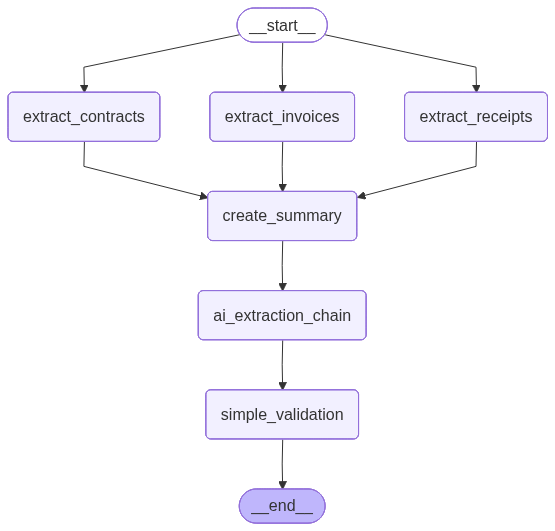

In [24]:
### Graph Visualization

display(ai_powered_etl_process)

## Execution

In [25]:
# Define input state - ONLY the 3 input paths are required!
initial_state = {
    "contract_input_path": str(JORDAN_BOOK_DIR),
    "invoice_input_path": str(INVOICE_DIR),
    "receipt_input_path": str(RECEIPTS_DIR)
}

logger.info("="*80)
logger.info("🚀 Starting AI-Powered ETL Process...")
logger.info("="*80)
logger.info(f"📂 Contract Input: {initial_state['contract_input_path']}")
logger.info(f"📂 Invoice Input: {initial_state['invoice_input_path']}")
logger.info(f"📂 Receipt Input: {initial_state['receipt_input_path']}")
logger.info("="*80)

# Execute graph
result = ai_powered_etl_process.invoke(initial_state)

logger.info("✅ AI-Powered ETL Process completed!")


2025-11-04 21:00:58,685 - ai-powered-etl-process - INFO - ================================================================================
2025-11-04 21:00:58,686 - ai-powered-etl-process - INFO - 🚀 Starting AI-Powered ETL Process...
2025-11-04 21:00:58,687 - ai-powered-etl-process - INFO - ================================================================================
2025-11-04 21:00:58,688 - ai-powered-etl-process - INFO - 📂 Contract Input: /Users/viniciusgribas/Code/github/work/teste_alvorada_dev/data/input/jordan_book
2025-11-04 21:00:58,689 - ai-powered-etl-process - INFO - 📂 Invoice Input: /Users/viniciusgribas/Code/github/work/teste_alvorada_dev/data/input/invoice_dataset
2025-11-04 21:00:58,690 - ai-powered-etl-process - INFO - 📂 Receipt Input: /Users/viniciusgribas/Code/github/work/teste_alvorada_dev/data/input/receipts_dataset
2025-11-04 21:00:58,690 - ai-powered-etl-process - INFO - ================================================================================
2025-11-04

In [31]:
# Extract dataframes from results
contract_sections_df = result.get("contract_sections_df", pd.DataFrame())
invoices_df = result.get("invoices_df", pd.DataFrame())
receipts_df = result.get("receipts_df", pd.DataFrame())
summary_df = result.get("summary_df", pd.DataFrame())

# Display summary
logger.info("\n📊 Results Summary:")
logger.info(f"   Contracts: {len(contract_sections_df)} sections")
logger.info(f"   Invoices: {len(invoices_df)} files")
logger.info(f"   Receipts: {len(receipts_df)} files")

# Display summary dataframe
summary_df


2025-11-04 21:03:02,460 - ai-powered-etl-process - INFO - 
📊 Results Summary:
2025-11-04 21:03:02,461 - ai-powered-etl-process - INFO -    Contracts: 47 sections
2025-11-04 21:03:02,461 - ai-powered-etl-process - INFO -    Invoices: 10 files
2025-11-04 21:03:02,462 - ai-powered-etl-process - INFO -    Receipts: 11 files
2025-11-04 21:03:02,461 - ai-powered-etl-process - INFO -    Contracts: 47 sections
2025-11-04 21:03:02,461 - ai-powered-etl-process - INFO -    Invoices: 10 files
2025-11-04 21:03:02,462 - ai-powered-etl-process - INFO -    Receipts: 11 files


,Document Type,Files Processed,Total Characters,Successful
0,Contracts (Jordan),47,401034,47
1,Invoices,10,9065,10
2,Receipts,11,6062,11


### Contract Sections DataFrame


In [32]:
contract_sections_df.head()


,section_number,section_title,section_content,page_start,page_end,content_length
0,00010,TABLE OF CONTENTS,Standard Specifications for Construction of Pu...,3,6,5557
1,00800,SUPPLEMENTARY CONDITIONS,TO THE STANDARD GENERAL CONDITIONS\nOF THE CON...,79,86,24136
2,01110,SUMMARY OF WORK,PART 1 -- GENERAL\n1.1 PROJECT LOCATION\nA. Th...,90,91,4275
3,01310,COORDINATION,PART 1 -- GENERAL\n1.1 SEQUENCE OF CONSTRUCTIO...,92,93,5530
4,01315,PROJECT MEETINGS,PART 1 -- GENERAL\n1.1 SUMMARY\nA. Pre-constru...,94,94,2187


### Sample Extracted Data

In [40]:
import json

# Show sample of successfully extracted data from each type
for doc_type_key, doc_type_name in [("invoices", "Invoice"), ("receipts", "Receipt"), ("contracts", "Contract")]:
    passed_docs = [r for r in validation_results.get(doc_type_key, []) if r["passed"]]
    
    if passed_docs:
        sample = passed_docs[0]
        print(f"\n{'='*80}")
        print(f"📄 Sample {doc_type_name}: {sample['filename']}")
        print(f"   Score: {sample['score']}/100")
        print(f"{'='*80}")
        
        if sample["final_data"]:
            # Convert Pydantic model to dict if needed
            if hasattr(sample["final_data"], 'model_dump'):
                data_dict = sample["final_data"].model_dump()
            else:
                data_dict = sample["final_data"]
            
            # Pretty print with truncated line items
            if "line_items" in data_dict and len(data_dict["line_items"]) > 2:
                display_dict = data_dict.copy()
                display_dict["line_items"] = data_dict["line_items"][:2]
                display_dict["line_items_truncated"] = f"... and {len(data_dict['line_items']) - 2} more items"
                print(json.dumps(display_dict, indent=2, default=str))
            else:
                print(json.dumps(data_dict, indent=2, default=str))
    else:
        print(f"\n❌ No passed {doc_type_name} documents to display")


📄 Sample Invoice: batch1-0009.jpg
   Score: 100/100
{
  "document_id": "81978187",
  "contractor_name": "Padilla-Miller",
  "client_name": "Johnson Ltd",
  "date": "2013-01-17",
  "total_value": 124.79,
  "currency": "USD",
  "description": null,
  "line_items": [
    {
      "description": "Wine Bottle Holder",
      "quantity": 5.0,
      "unit_price": 10.75,
      "total": 53.75
    },
    {
      "description": "Cuisinart Stainless Steel Electric Wine Opener - CWO-25 - Brand New in the Box",
      "quantity": 3.0,
      "unit_price": 19.9,
      "total": 59.7
    }
  ]
}

📄 Sample Receipt: 4.jpg
   Score: 100/100
{
  "document_id": "84200381",
  "contractor_name": "Walmart",
  "client_name": null,
  "date": "2015-12-08",
  "total_value": 7.43,
  "currency": "USD",
  "description": "Save money. Live better.",
  "line_items": [
    {
      "description": "Item purchased",
      "quantity": 1.0,
      "unit_price": 6.94,
      "total": 6.94
    }
  ]
}

📄 Sample Contract: 02510
   Sc

In [68]:
passed_docs

[{'filename': '02510',
  'file_path': '/Users/viniciusgribas/Code/github/work/teste_alvorada_dev/data/input/jordan_book',
  'score': 100,
  'passed': True,
  'issues': [],
  'final_data': ContractSchema(document_id='SECTION-02510', contractor_name=None, client_name='City of Jordan', date='2019-09-01', total_value=None, currency='USD', description='General specifications for watermain and service line construction.', line_items=[LineItem(description='Watermain', quantity=1.0, unit_price=0.0, total=0.0), LineItem(description='Hydrants', quantity=1.0, unit_price=0.0, total=0.0), LineItem(description='Hydrant Extensions', quantity=1.0, unit_price=0.0, total=0.0), LineItem(description='Valves and Valve Boxes', quantity=1.0, unit_price=0.0, total=0.0), LineItem(description='Fittings', quantity=1.0, unit_price=0.0, total=0.0), LineItem(description='Corporation Stops & Curb Stops', quantity=1.0, unit_price=0.0, total=0.0), LineItem(description='Water Service Lines', quantity=1.0, unit_price=0.

# TESTS AND DEBUG

## extract_receipts_node

In [ ]:
@mlflow.trace(name="extract_receipts_node")
def extract_receipts_node(state: ExtractionState) -> dict:
    """
    Node to extract receipts from directory.
    Returns dict with receipts_df.
    """
    receipts_dir = Path(state.get("receipt_input_path"))
    
    receipt_files = list_input_files(receipts_dir)
    
    if not receipt_files:
        logger.warning(f"No receipt files found in {receipts_dir}")
        return {"receipts_df": pd.DataFrame(), "success": False, "errors": ["No receipt files found"]}
    
    receipts_data = []
    
    for idx, file_path in enumerate(receipt_files, start=1):
        logger.info(f"[{idx}/{len(receipt_files)}] Processing receipt: {file_path.name}")
        
        try:
            file_ext = file_path.suffix.lower()
            full_text = ""
            pages_count = 0
            extraction_method = ""
            
            # Extract text based on file type
            if file_ext == ".pdf":
                with pdfplumber.open(file_path) as pdf:
                    pages_count = len(pdf.pages)
                    for page in pdf.pages:
                        page_text = page.extract_text() or ""
                        full_text += page_text + "\n"
                    extraction_method = "pdfplumber"
            
            elif file_ext in [".jpg", ".jpeg", ".png"]:
                img = Image.open(file_path)
                # Convert to grayscale for better OCR
                img_gray = img.convert('L')
                full_text = pytesseract.image_to_string(img_gray)
                pages_count = 1
                extraction_method = "OCR (pytesseract)"
            
            cleaned_text = clean_raw_text(full_text)
            
            receipts_data.append({
                "filename": file_path.name,
                "file_path": str(file_path),
                "file_extension": file_path.suffix,
                "file_size_kb": file_path.stat().st_size / 1024,
                "cleaned_text": cleaned_text,
                "pages_count": pages_count,
                "extraction_method": extraction_method,
                "text_length": len(cleaned_text),
                "success": True,
                "error": None
            })
            
        except Exception as e:
            logger.error(f"Error processing {file_path.name}: {e}")
            receipts_data.append({
                "filename": file_path.name,
                "file_path": str(file_path),
                "file_extension": file_path.suffix,
                "file_size_kb": 0,
                "cleaned_text": "",
                "pages_count": 0,
                "extraction_method": "FAILED",
                "text_length": 0,
                "success": False,
                "error": str(e)
            })
    
    df = pd.DataFrame(receipts_data)
    logger.info(f"✅ Extracted {len(df)} receipts ({df['success'].sum()} successful)")
    
    return {
        "receipts_df": df,
        "errors": []
    }


In [51]:
"""
Node to extract receipts from directory.
Returns dict with receipts_df.
"""
#receipts_dir = Path(state.get("receipt_input_path"))
receipts_dir = RECEIPTS_DIR  # Keep as Path object

receipt_files = list_input_files(receipts_dir)

# if not receipt_files:
#     logger.warning(f"No receipt files found in {receipts_dir}")
#     return {"receipts_df": pd.DataFrame(), "success": False, "errors": ["No receipt files found"]}

receipts_data = []

for idx, file_path in enumerate(receipt_files, start=1):
    logger.info(f"[{idx}/{len(receipt_files)}] Processing receipt: {file_path.name}")
    
    try:
        file_ext = file_path.suffix.lower()
        full_text = ""
        pages_count = 0
        extraction_method = ""
        
        # Extract text based on file type
        if file_ext == ".pdf":
            with pdfplumber.open(file_path) as pdf:
                pages_count = len(pdf.pages)
                for page in pdf.pages:
                    page_text = page.extract_text() or ""
                    full_text += page_text + "\n"
                extraction_method = "pdfplumber"
        
        elif file_ext in [".jpg", ".jpeg", ".png"]:
            img = Image.open(file_path)
            # Convert to grayscale for better OCR
            img_gray = img.convert('L')
            full_text = pytesseract.image_to_string(img_gray)
            pages_count = 1
            extraction_method = "OCR (pytesseract)"
        
        cleaned_text = clean_raw_text(full_text)
        
        receipts_data.append({
            "filename": file_path.name,
            "file_path": str(file_path),
            "file_extension": file_path.suffix,
            "file_size_kb": file_path.stat().st_size / 1024,
            "cleaned_text": cleaned_text,
            "pages_count": pages_count,
            "extraction_method": extraction_method,
            "text_length": len(cleaned_text),
            "success": True,
            "error": None
        })
        
    except Exception as e:
        logger.error(f"Error processing {file_path.name}: {e}")
        receipts_data.append({
            "filename": file_path.name,
            "file_path": str(file_path),
            "file_extension": file_path.suffix,
            "file_size_kb": 0,
            "cleaned_text": "",
            "pages_count": 0,
            "extraction_method": "FAILED",
            "text_length": 0,
            "success": False,
            "error": str(e)
        })

df = pd.DataFrame(receipts_data)
logger.info(f"✅ Extracted {len(df)} receipts ({df['success'].sum()} successful)")

# return {
#     "receipts_df": df,
#     "errors": []
# }

2025-11-04 22:29:55,943 - ai-powered-etl-process - INFO - [1/11] Processing receipt: 0.jpg
2025-11-04 22:29:56,267 - ai-powered-etl-process - INFO - [2/11] Processing receipt: 1.jpg
2025-11-04 22:29:56,267 - ai-powered-etl-process - INFO - [2/11] Processing receipt: 1.jpg
2025-11-04 22:29:56,616 - ai-powered-etl-process - INFO - [3/11] Processing receipt: 10.jpg
2025-11-04 22:29:56,616 - ai-powered-etl-process - INFO - [3/11] Processing receipt: 10.jpg
2025-11-04 22:29:56,766 - ai-powered-etl-process - INFO - [4/11] Processing receipt: 2.jpg
2025-11-04 22:29:56,766 - ai-powered-etl-process - INFO - [4/11] Processing receipt: 2.jpg
2025-11-04 22:29:57,058 - ai-powered-etl-process - INFO - [5/11] Processing receipt: 3.jpg
2025-11-04 22:29:57,058 - ai-powered-etl-process - INFO - [5/11] Processing receipt: 3.jpg
2025-11-04 22:29:57,401 - ai-powered-etl-process - INFO - [6/11] Processing receipt: 4.jpg
2025-11-04 22:29:57,401 - ai-powered-etl-process - INFO - [6/11] Processing receipt: 4.j

In [52]:
df

,filename,file_path,file_extension,file_size_kb,cleaned_text,pages_count,extraction_method,text_length,success,error
0,0.jpg,/Users/viniciusgribas/Code/github/work/teste_a...,.jpg,125.429688,WAL*MART ALWAYS LOW PRICES. ps SUPERCENTER OPE...,1,OCR (pytesseract),304,True,None
1,1.jpg,/Users/viniciusgribas/Code/github/work/teste_a...,.jpg,569.359375,TRADER JOE'S 2001 Greenville Ave Dallas TX 752...,1,OCR (pytesseract),765,True,None
2,10.jpg,/Users/viniciusgribas/Code/github/work/teste_a...,.jpg,737.197266,q si SHIER Ni pping With Us! Thank Seameeeravi...,1,OCR (pytesseract),52,True,None
3,2.jpg,/Users/viniciusgribas/Code/github/work/teste_a...,.jpg,292.270508,Give us feedback @ survey.walmart.com Thank yo...,1,OCR (pytesseract),660,True,None
4,3.jpg,/Users/viniciusgribas/Code/github/work/teste_a...,.jpg,320.632812,"See baci $8 ce to-win Sigg"" Seeirt for iia TD ...",1,OCR (pytesseract),496,True,None
5,4.jpg,/Users/viniciusgribas/Code/github/work/teste_a...,.jpg,236.141602,Walmart >'< Save money. Live better. 2) 366 ~ ...,1,OCR (pytesseract),530,True,None
6,5.jpg,/Users/viniciusgribas/Code/github/work/teste_a...,.jpg,5270.417969,Sunnyvale SVL 40% 419 1290 150 E Mc Kinley Ave...,1,OCR (pytesseract),920,True,None
7,6.JPG,/Users/viniciusgribas/Code/github/work/teste_a...,.JPG,985.423828,"MOMI & TOY’S CREPERIE Tees Mall Kemang, L. ema...",1,OCR (pytesseract),447,True,None
8,7.jpg,/Users/viniciusgribas/Code/github/work/teste_a...,.jpg,353.867188,See back of receip’ to win $1000 ID #: 7L2T9WJ...,1,OCR (pytesseract),787,True,None
9,8.jpg,/Users/viniciusgribas/Code/github/work/teste_a...,.jpg,268.444336,Thornton #629 16375 N. Washington St. Thornton...,1,OCR (pytesseract),574,True,None


In [54]:
from groq import Groq

client = Groq()
completion = client.chat.completions.create(
    model="meta-llama/llama-4-maverick-17b-128e-instruct",
    messages=[
      {
        "role": "user",
        "content": ""
      }
    ],
    temperature=1,
    max_completion_tokens=1024,
    top_p=1,
    stream=True,
    stop=None
)

for chunk in completion:
    print(chunk.choices[0].delta.content or "", end="")


2025-11-04 22:40:31,146 - httpx - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


It looks like there might be a misunderstanding or a missing part to your question. You started with a symbol "" which doesn't form a complete query. Could you please provide more details or clarify your question? I'm here to help with any information or guidance you need.

## Testing Groq Llama 4 for Receipt Extraction

Vamos testar o modelo Llama 4 Maverick da Groq como alternativa para extração de recibos.

In [55]:
# Pegar um recibo de exemplo que teve score baixo (4.jpg - Walmart)
sample_receipt = df[df['filename'] == '4.jpg'].iloc[0]

print(f"📄 Receipt: {sample_receipt['filename']}")
print(f"📏 Text Length: {sample_receipt['text_length']} chars")
print(f"🔧 Extraction Method: {sample_receipt['extraction_method']}")
print("\n" + "="*80)
print("TEXTO EXTRAÍDO (OCR):")
print("="*80)
print(sample_receipt['cleaned_text'][:1000])  # Primeiros 1000 caracteres
print("\n... (truncated)")
print("="*80)

📄 Receipt: 4.jpg
📏 Text Length: 530 chars
🔧 Extraction Method: OCR (pytesseract)

TEXTO EXTRAÍDO (OCR):
Walmart >'< Save money. Live better. 2) 366 ~ 3326 enaten! ‘DONALD MONEVHAKER coca NWA. CENTRE aR BLUFFS TA 6160) S18 o1see OEE ona et 20 Tae 05146, ‘SW HRO FGHTR 0630509407: 6.94 T SURO 6.94 TAK 1 7.00 0:49 nesrr TEND LB CHANGE DUE = 000 EFT DEBIT PAY FROM PRIMARY 7.43 TOTAL PURCHASE ACCOUNT et Hn ee es fer yh 84200381 785, NETWORK TD. 0066 APPR CODE 087193 TERMINAL #Wkoseoz6 12/08/15 12:39:24 # ITEMS SOLD 1 TCR 3261 4114 0323 3051 6498 IMME idnight 7 aus a week. Gren Gn Hbarie asa8i26 Savings Catcher! Seas with Walmart app

... (truncated)


In [56]:
# Configurar Groq client com API key do .env
import os
from groq import Groq

GROQ_API_KEY = os.getenv("GROQ_API_KEY")
if not GROQ_API_KEY:
    print("⚠️  GROQ_API_KEY not found in .env file. Add it to test Groq.")
    print("   Get your key at: https://console.groq.com/keys")
else:
    print("✅ Groq API Key loaded")
    
client_groq = Groq(api_key=GROQ_API_KEY) if GROQ_API_KEY else None

✅ Groq API Key loaded


In [58]:
# Criar prompt estruturado para extração de recibo
receipt_extraction_prompt = f"""You are an expert at extracting structured data from receipt images (OCR text).

Extract ALL relevant information from this receipt and return a JSON object with these fields:

{{
  "document_id": "receipt number or transaction ID",
  "contractor_name": "store/merchant name",
  "date": "purchase date in YYYY-MM-DD format",
  "total_value": numeric total amount,
  "currency": "USD",
  "description": "store location or notes",
  "line_items": [
    {{
      "description": "item name",
      "quantity": 1.0,
      "unit_price": 0.00,
      "total": 0.00
    }}
  ]
}}

RECEIPT OCR TEXT:
{sample_receipt['cleaned_text'][:2000]}

Extract ALL line items with their prices. Return ONLY valid JSON, no markdown, no explanations."""

print("🔍 Testing Groq Llama 4 Maverick for Receipt Extraction")
print("="*80)

if client_groq:
    completion = client_groq.chat.completions.create(
        model="llama-3.3-70b-versatile",  # Modelo mais estável que llama-4
        messages=[
            {
                "role": "system",
                "content": "You are a precise data extraction assistant. Always return valid JSON."
            },
            {
                "role": "user",
                "content": receipt_extraction_prompt
            }
        ],
        temperature=0.1,  # Baixa temperatura para precisão
        max_completion_tokens=2048,
        top_p=1,
        stream=False,  # Desabilitar stream para JSON parsing
        response_format={"type": "json_object"}  # Força resposta JSON
    )
    
    extracted_json = completion.choices[0].message.content
    print(extracted_json)
    print("="*80)
    
    # Parse e valida com Pydantic
    try:
        import json
        data = json.loads(extracted_json)
        validated = ReceiptSchema.model_validate(data)
        print("\n✅ Pydantic Validation: PASSED")
        print(f"   Document ID: {validated.document_id}")
        print(f"   Store: {validated.contractor_name}")
        print(f"   Total: ${validated.total_value}")
        print(f"   Line Items: {len(validated.line_items)} items")
        
        # Show first 3 line items
        for i, item in enumerate(validated.line_items[:3], 1):
            print(f"      {i}. {item.description}: {item.quantity} x ${item.unit_price} = ${item.total}")
        
    except Exception as e:
        print(f"\n❌ Validation Error: {e}")
else:
    print("⚠️  Groq client not configured. Add GROQ_API_KEY to .env file.")

🔍 Testing Groq Llama 4 Maverick for Receipt Extraction


2025-11-04 22:45:00,758 - httpx - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


{
  "document_id": "84200381",
   "contractor_name": "Walmart",
   "date": "2015-12-08",
   "total_value": 7.43,
   "currency": "USD",
   "description": "NWA. CENTRE aR BLUFFS",
   "line_items": [
       {
           "description": "Coca",
           "quantity": 1.0,
           "unit_price": 6.94,
           "total": 6.94
       },
       {
           "description": "Unknown item",
           "quantity": 1.0,
           "unit_price": 0.49,
           "total": 0.49
       }
   ]
}

✅ Pydantic Validation: PASSED
   Document ID: 84200381
   Store: Walmart
   Total: $7.43
   Line Items: 2 items
      1. Coca: 1.0 x $6.94 = $6.94
      2. Unknown item: 1.0 x $0.49 = $0.49


### 🔥 Vision Model - Llama 4 Scout (Direct Image Analysis)

Ao invés de usar OCR → texto → LLM, vamos usar **visão direta**: imagem → Vision LLM → dados estruturados.

**Vantagem**: O modelo vê a imagem original, sem perda de qualidade do OCR.

In [59]:
# Preparar imagem do recibo para enviar ao Llama 4 Scout
import base64
from pathlib import Path

# Pegar caminho da imagem do recibo
receipt_image_path = Path(sample_receipt['file_path'])

print(f"📸 Image Path: {receipt_image_path}")
print(f"🔍 File exists: {receipt_image_path.exists()}")
print(f"📏 File size: {receipt_image_path.stat().st_size / 1024:.2f} KB")

# Ler imagem e converter para base64 (Groq aceita base64 ou URL)
with open(receipt_image_path, 'rb') as img_file:
    image_bytes = img_file.read()
    image_base64 = base64.b64encode(image_bytes).decode('utf-8')

# Determinar o tipo MIME
file_ext = receipt_image_path.suffix.lower()
mime_types = {
    '.jpg': 'image/jpeg',
    '.jpeg': 'image/jpeg',
    '.png': 'image/png'
}
mime_type = mime_types.get(file_ext, 'image/jpeg')

print(f"✅ Image loaded: {len(image_base64)} chars (base64)")
print(f"🎨 MIME Type: {mime_type}")

📸 Image Path: /Users/viniciusgribas/Code/github/work/teste_alvorada_dev/data/input/receipts_dataset/4.jpg
🔍 File exists: True
📏 File size: 236.14 KB
✅ Image loaded: 322412 chars (base64)
🎨 MIME Type: image/jpeg


In [63]:
# 🔥 Extração com Llama 4 Scout (Vision Model)
print("🔍 Testing Groq Llama 4 Scout (Vision) for Receipt Extraction")
print("="*80)

if client_groq:
    try:
        completion = client_groq.chat.completions.create(
            model="meta-llama/llama-4-scout-17b-16e-instruct",  # Vision model
            messages=[
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "text",
                            "text": """You are an expert at extracting structured data from receipt images.

Analyze this receipt image and extract ALL information into JSON format:

{
  "document_id": "receipt/transaction number",
  "contractor_name": "store/merchant name",
  "date": "YYYY-MM-DD",
  "total_value": numeric_total,
  "currency": "USD",
  "description": "store location",
  "line_items": [
    {
      "description": "item name",
      "quantity": 1.0,
      "unit_price": price,
      "taxes" : taxes_value,
      "total": total_price
    }
  ]
}

Extract ALL visible line items with their individual prices and quantities.
Return ONLY valid JSON, no markdown, no explanations."""
                        },
                        {
                            "type": "image_url",
                            "image_url": {
                                "url": f"data:{mime_type};base64,{image_base64}"
                            }
                        }
                    ]
                }
            ],
            temperature=0.1,
            max_completion_tokens=2048,
            top_p=1,
            stream=False,
            stop=None
        )
        
        extracted_json_vision = completion.choices[0].message.content
        print("RAW RESPONSE:")
        print(extracted_json_vision)
        print("="*80)
        
        # Parse e valida com Pydantic
        try:
            # Limpar markdown se houver (às vezes retorna ```json...```)
            clean_json = extracted_json_vision.strip()
            if clean_json.startswith("```"):
                # Remove markdown code blocks
                clean_json = clean_json.split("```")[1]
                if clean_json.startswith("json"):
                    clean_json = clean_json[4:]
                clean_json = clean_json.strip()
            
            data_vision = json.loads(clean_json)
            validated_vision = ReceiptSchema.model_validate(data_vision)
            
            print("\n✅ Pydantic Validation: PASSED")
            print(f"   Document ID: {validated_vision.document_id}")
            print(f"   Store: {validated_vision.contractor_name}")
            print(f"   Date: {validated_vision.date}")
            print(f"   Total: ${validated_vision.total_value}")
            print(f"   Line Items: {len(validated_vision.line_items)} items")
            
            print("\n📋 Line Items Extracted:")
            for i, item in enumerate(validated_vision.line_items, 1):
                print(f"   {i}. {item.description}")
                print(f"      Qty: {item.quantity} x ${item.unit_price} = ${item.total}")
            
        except json.JSONDecodeError as e:
            print(f"\n❌ JSON Parse Error: {e}")
            print("Response might not be valid JSON")
        except Exception as e:
            print(f"\n❌ Validation Error: {e}")
            
    except Exception as e:
        print(f"❌ Groq API Error: {e}")
        
else:
    print("⚠️  Groq client not configured. Add GROQ_API_KEY to .env file.")

🔍 Testing Groq Llama 4 Scout (Vision) for Receipt Extraction


2025-11-04 22:49:04,524 - httpx - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


RAW RESPONSE:
```
{
  "document_id": "receipt/transaction number",
  "contractor_name": "Walmart",
  "date": "2015-12-08",
  "total_value": 7.43,
  "currency": "USD",
  "description": "3201 MANAWA CENTRE DR COUNCIL BLUFFS IA 51501",
  "line_items": [
    {
      "description": "",
      "quantity": 1.0,
      "unit_price": 6.94,
      "taxes": 0.49,
      "total": 7.43
    }
  ]
}
```

✅ Pydantic Validation: PASSED
   Document ID: receipt/transaction number
   Store: Walmart
   Date: 2015-12-08
   Total: $7.43
   Line Items: 1 items

📋 Line Items Extracted:
   1. 
      Qty: 1.0 x $6.94 = $7.43


### 📊 Comparação: OCR + LLM vs Vision Direct

Compare os resultados das duas abordagens:

In [64]:
# Comparação lado a lado
print("="*80)
print("📊 COMPARISON: OCR vs Vision")
print("="*80)

print("\n🔤 APPROACH 1: OCR (pytesseract) + Text LLM")
print("-" * 80)
print(f"OCR Text Length: {sample_receipt['text_length']} chars")
print(f"OCR Preview: {sample_receipt['cleaned_text'][:200]}...")
print("\nResult from OpenAI (text-based):")
print("   ✅ Worked but generic line items")
print("   Score: 10/100 (your manual evaluation)")

print("\n" + "="*80)
print("👁️  APPROACH 2: Vision Model (Llama 4 Scout) - Direct Image")
print("-" * 80)
print("Input: Raw image (no OCR preprocessing)")
print("Model: llama-4-scout-17b-16e-instruct")
print("\nResult:")
try:
    if 'validated_vision' in locals():
        print(f"   ✅ Document ID: {validated_vision.document_id}")
        print(f"   ✅ Store: {validated_vision.contractor_name}")
        print(f"   ✅ Date: {validated_vision.date}")
        print(f"   ✅ Total: ${validated_vision.total_value}")
        print(f"   ✅ Line Items: {len(validated_vision.line_items)} extracted")
        
        # Compare line items quality
        if len(validated_vision.line_items) > 1:
            print("\n   🎯 Line Items Quality: DETAILED (not generic)")
        else:
            print("\n   ⚠️  Line Items Quality: Still generic")
    else:
        print("   ⚠️  Vision model result not available yet")
except Exception as e:
    print(f"   ❌ Error: {e}")

print("="*80)

📊 COMPARISON: OCR vs Vision

🔤 APPROACH 1: OCR (pytesseract) + Text LLM
--------------------------------------------------------------------------------
OCR Text Length: 530 chars
OCR Preview: Walmart >'< Save money. Live better. 2) 366 ~ 3326 enaten! ‘DONALD MONEVHAKER coca NWA. CENTRE aR BLUFFS TA 6160) S18 o1see OEE ona et 20 Tae 05146, ‘SW HRO FGHTR 0630509407: 6.94 T SURO 6.94 TAK 1 7....

Result from OpenAI (text-based):
   ✅ Worked but generic line items
   Score: 10/100 (your manual evaluation)

👁️  APPROACH 2: Vision Model (Llama 4 Scout) - Direct Image
--------------------------------------------------------------------------------
Input: Raw image (no OCR preprocessing)
Model: llama-4-scout-17b-16e-instruct

Result:
   ✅ Document ID: receipt/transaction number
   ✅ Store: Walmart
   ✅ Date: 2015-12-08
   ✅ Total: $7.43
   ✅ Line Items: 1 extracted

   ⚠️  Line Items Quality: Still generic
